# Spaceship Titanic

**Project Brief**

Welcome to the year 2912, where your data science skills are needed to solve a cosmic mystery. We've received a transmission from four lightyears away and things aren't looking good.

The Spaceship Titanic was an interstellar passenger liner launched a month ago. With almost 13,000 passengers on board, the vessel set out on its maiden voyage transporting emigrants from our solar system to three newly habitable exoplanets orbiting nearby stars.

While rounding Alpha Centauri en route to its first destination—the torrid 55 Cancri E—the unwary Spaceship Titanic collided with a spacetime anomaly hidden within a dust cloud. Sadly, it met a similar fate as its namesake from 1000 years before. Though the ship stayed intact, almost half of the passengers were transported to an alternate dimension!

To help rescue crews and retrieve the lost passengers, you are challenged to predict which passengers were transported by the anomaly using records recovered from the spaceship’s damaged computer system.

Help save them and change history!

**Variables:**

PassengerId - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.

HomePlanet - The planet the passenger departed from, typically their planet of permanent residence.

CryoSleep - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.

Cabin - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.

Destination - The planet the passenger will be debarking to.

Age - The age of the passenger.

VIP - Whether the passenger has paid for special VIP service during the voyage.

RoomService, FoodCourt, ShoppingMall, Spa, VRDeck - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.

Name - The first and last names of the passenger.

Transported - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.

**To be Continued:**

- Further feature engineering
- Exploring different imputations for missing data
- Trying PCA as a dimensionality reduction technique
- Removing target leak
- Constructing a pipeline
- Tidying up the notebook and better annotation

## 1. Importing Packages & Data

In [58]:
## Importing relevant packages

import pandas as pd
import plotly.express as px
import numpy as np
import math

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.model_selection import RandomizedSearchCV
from collinearity import SelectNonCollinear

import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV

from sklearn.datasets import make_classification
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import StackingClassifier, VotingClassifier

from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV

In [59]:
## Importing the data and concating for easier data quality evaluation, cleaning & feature engineering

train=pd.read_csv('train.csv')

test=pd.read_csv('test.csv')

data = pd.concat([train, test], axis=0,ignore_index=True)

## 2. EDA in seperate notebook

## 3. Data Cleaning

In [60]:
## Checking for missing values
data.isna().sum()

PassengerId        0
HomePlanet       288
CryoSleep        310
Cabin            299
Destination      274
Age              270
VIP              296
RoomService      263
FoodCourt        289
ShoppingMall     306
Spa              284
VRDeck           268
Name             294
Transported     4277
dtype: int64

**Spend Variables**

'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck'

Since the median was 0 for all these variables, we will use it to replace missing values

In [61]:
cols=['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']
data[cols] = data[cols].replace(np.nan,0)

**VIP**

Only about 2% of passengers were considered VIPS, so we will assume those with missing values are not VIP

In [62]:
data['VIP'] = data['VIP'].replace(np.nan,False).astype(int)

**Age**

We will use median age to replace missing values

In [63]:
data['Age'] = data['Age'].replace(np.nan,data.Age.median())

**CyroSleep**

We will randomly assign missing values proportionionally 

In [64]:
data['CryoSleep'].mean()

0.3618483412322275

In [65]:

data['CryoSleep']=data['CryoSleep'].apply(lambda x: x if not math.isnan(x) else 
                        np.random.choice([True, False], p=[0.3618483412322275, 1-0.3618483412322275]))

**Home Planet**

We will replace missing values proportionally to the rest of the population 

In [66]:
data.HomePlanet.value_counts()/len(data[data['HomePlanet'].isna()==False])

Earth     0.541318
Europa    0.247043
Mars      0.211639
Name: HomePlanet, dtype: float64

In [67]:
data['HomePlanet']=data['HomePlanet'].apply(lambda x: x if not pd.isnull(x) else 
                        np.random.choice(['Earth', 'Europa', 'Mars'], 
                                         p=[0.541318, 0.247043, 0.211639]))

**Destination**

We will replace missing values proportionally to the rest of the population

In [68]:
data.Destination.value_counts()/len(data[data['Destination'].isna()==False])

TRAPPIST-1e      0.698724
55 Cancri e      0.208018
PSO J318.5-22    0.093258
Name: Destination, dtype: float64

In [69]:
data['Destination']=data['Destination'].apply(lambda x: x if not pd.isnull(x) else 
                        np.random.choice(['TRAPPIST-1e', '55 Cancri e', 'PSO J318.5-22'],
                                         p=[0.698724, 0.208018, 0.093258]))

**Cabin**

In [70]:
data['Cabin'] = data['Cabin'].fillna(method='ffill')

**Name**

In [71]:
data['Name'] = data['Name'].fillna(method='ffill')

In [72]:
## We now have a clean dataset

data.isna().sum()

PassengerId        0
HomePlanet         0
CryoSleep          0
Cabin              0
Destination        0
Age                0
VIP                0
RoomService        0
FoodCourt          0
ShoppingMall       0
Spa                0
VRDeck             0
Name               0
Transported     4277
dtype: int64

## 4. Feature Engineering

### Transforming Categorical Variables

**Name**

In [73]:
data['Surname']=data['Name'].str.split(n=2).str[-1].str.upper()

data['Number_in_family']=data['Surname'].map(dict(data['Surname'].value_counts()))

**PassengerID**

In [74]:
## Creating group id variable

data['PassengerId_Group']= data['PassengerId'].str[:4]

In [75]:
## Passenger ID variable
data['PassengerId_Single']=data['PassengerId'].str[-2:]

In [76]:
## Creating number in group variable

data['number_in_group']=data['PassengerId_Group'].map(dict(data['PassengerId_Group'].value_counts()))

**Home Planet**

In [77]:
## Target Encoding

data['HomePlanet_Target']=data['HomePlanet'].map(dict(train.groupby('HomePlanet')['Transported'].mean()))

**Destination**

In [78]:
## Target Encoding
data['Destination_Target']=data['Destination'].map(dict(train.groupby('Destination')['Transported'].mean()))

**Cabin**

In [79]:
## Creating Cabin number variable
data['Cabin_number']=data['Cabin'].str[2:-2]

In [80]:
## Creating Cabin Side variable (one-hot-encoding since binary)
data['Cabin_Side_P']=data['Cabin'].str[-1].map({"P":1, "S":0})

In [81]:
## Creating Cabin deck variable for datasets

train['Cabin_Deck']=train['Cabin'].str[0]
data['Cabin_Deck']=data['Cabin'].str[0]

In [82]:
## Target Encoding
data['cabin_deck_target']=data['Cabin_Deck'].map(dict(train.groupby('Cabin_Deck')['Transported'].mean()))

In [83]:
data.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,...,Number_in_family,PassengerId_Group,PassengerId_Single,number_in_group,HomePlanet_Target,Destination_Target,Cabin_number,Cabin_Side_P,Cabin_Deck,cabin_deck_target
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,0,0.0,0.0,0.0,...,4,0001,01,1,0.658846,0.471175,0,1,B,0.734275
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,0,109.0,9.0,25.0,...,5,0002,01,1,0.423946,0.471175,0,0,F,0.439871
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,1,43.0,3576.0,0.0,...,7,0003,01,2,0.658846,0.471175,0,0,A,0.496094
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,0,0.0,1283.0,371.0,...,7,0003,02,2,0.658846,0.471175,0,0,A,0.496094
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,0,303.0,70.0,151.0,...,9,0004,01,1,0.423946,0.471175,1,0,F,0.439871


### New Features Engineered

In [84]:
data['family_and_group_num']=data['Number_in_family']*data['number_in_group']

In [85]:
## Spend Variables

## Log transformations (smoothing)

cols=['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']

for var in cols:
    data[str(var)+'_log']= data[var].map(lambda i: np.log(i) if i > 0 else 0) 
    
## Different Combinations of Spend

data['TotalSpend']= data['RoomService']+data['FoodCourt']+ data['ShoppingMall']+ data['Spa']+ data['VRDeck']

data['RoomService_FoodCourt_Spend']=  data['RoomService']+data['FoodCourt']

data['RoomService_ShoppingMall_Spend']=  data['RoomService']+data['ShoppingMall']

data['RoomService_Spa_Spend']=  data['RoomService']+data['Spa']

data['RoomService_VRDeck_Spend']=  data['RoomService']+data['VRDeck']

data['FoodCourt_ShoppingMall_Spend']=  data['FoodCourt']+data['ShoppingMall']

data['FoodCourt_Spa_Spend'] =  data['FoodCourt']+data['Spa']

data['FoodCourt_VRDeck_Spend']=  data['FoodCourt']+data['VRDeck']

data['ShoppingMall_Spa_Spend']=  data['ShoppingMall']+data['Spa']

data['ShoppingMall_VRDeck_Spend']=  data['ShoppingMall']+data['VRDeck']

data['Spa_VRDeck_Spend']=  data['Spa']+data['VRDeck']


In [86]:
## Age Variables

data['Age_log']= data['Age'].map(lambda x: np.log(x) if x > 0 else 0)

data['Age_Infant']= data['Age'].apply(lambda x: True if x <= 5 else False)

data['Age_Child']= data['Age'].apply(lambda x: True if x <= 12 else False)

data['Age_Teen']= data['Age'].apply(lambda x: True if x <= 18 else False)

data['Age_Elder']= data['Age'].apply(lambda x: True if x >= 60 else False)

In [87]:
## CyroSleep Variables

## CyroSleep in different Cabin Decks

for deck in data['Cabin_Deck'].unique():
    data['Cabin_Deck_CryoSleep_'+str(deck)]= (data['Cabin_Deck']==deck)&(data['CryoSleep']==True)
    
## CyroSleep for different Destinations

for dest in data['Destination'].unique():
    data['Destination_CryoSleep_'+str(dest)]= (data['Destination']==dest)&(data['CryoSleep']==True)
    
## CyroSleep for different HomePlanets

for home in data['HomePlanet'].unique():
    data['Cabin_Deck_CryoSleep_'+str(home)]= (data['Cabin_Deck']==home)&(data['CryoSleep']==True)
    
## CyroSleep Cabin Side

data['Cabin_Side_P_Cryosleep']= (data['Cabin_Side_P']==1)&(data['CryoSleep']==True)

## CyroSleep Infants and Childs

data['Age_Infant_Cryosleep']=  (data['Age_Infant']==1)&(data['CryoSleep']==True)

data['Age_Child_Cryosleep']=  (data['Age_Child']==1)&(data['CryoSleep']==True)

data['Age_Teen_Cryosleep']=  (data['Age_Teen']==1)&(data['CryoSleep']==True)

data['Age_Elder_Cryosleep']=  (data['Age_Elder']==1)&(data['CryoSleep']==True)

In [88]:
## VIP in different Cabin Decks
for deck in data['Cabin_Deck'].unique():
    data['Cabin_Deck_VIP_'+str(deck)]= (data['Cabin_Deck']==deck)&(data['VIP']==True)
    
## VIP Cabin Side
data['Cabin_Side_P_VIP']= (data['Cabin_Side_P']==1)&(data['VIP']==True)

In [89]:
## Dropping Categorical Variables
data=data.drop(['HomePlanet','Destination','Cabin','Cabin_Deck','Name','Surname'], axis=1)

## 4. Feature Selection

In [90]:
## Setting index
data=data.set_index('PassengerId', drop=True)

#
labelled=data[data['Transported'].notnull()==True]

X=labelled.drop(['Transported'], axis=1) 
y=labelled['Transported'].astype(int) 

**Filter Method (Univariate Tests)**

In [91]:
## Filtering for the top 40 variables

fs = SelectKBest(score_func=f_classif,k=40)
X_selected = fs.fit_transform(X, y)

## Identifying the names and filtering for the columns
cols = fs.get_support(indices=True)
features_df_new = X.iloc[:,cols]
X=features_df_new
X.columns

/Users/adamtassabehji/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:115: UserWarning: Features [46 50 51 52 65] are constant.
  UserWarning)
/Users/adamtassabehji/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


Index(['CryoSleep', 'Age', 'RoomService', 'Spa', 'VRDeck', 'number_in_group',
       'HomePlanet_Target', 'Destination_Target', 'Cabin_Side_P',
       'cabin_deck_target', 'RoomService_log', 'FoodCourt_log',
       'ShoppingMall_log', 'Spa_log', 'VRDeck_log', 'TotalSpend',
       'RoomService_ShoppingMall_Spend', 'RoomService_Spa_Spend',
       'RoomService_VRDeck_Spend', 'FoodCourt_Spa_Spend',
       'ShoppingMall_Spa_Spend', 'ShoppingMall_VRDeck_Spend',
       'Spa_VRDeck_Spend', 'Age_log', 'Age_Infant', 'Age_Child', 'Age_Teen',
       'Cabin_Deck_CryoSleep_B', 'Cabin_Deck_CryoSleep_F',
       'Cabin_Deck_CryoSleep_A', 'Cabin_Deck_CryoSleep_G',
       'Cabin_Deck_CryoSleep_D', 'Cabin_Deck_CryoSleep_C',
       'Destination_CryoSleep_TRAPPIST-1e',
       'Destination_CryoSleep_PSO J318.5-22',
       'Destination_CryoSleep_55 Cancri e', 'Cabin_Side_P_Cryosleep',
       'Age_Infant_Cryosleep', 'Age_Child_Cryosleep', 'Age_Teen_Cryosleep'],
      dtype='object')

**Removing highly correlated variables to avoid multicollinearity**

**Wrapper (Forward Step Selection with Logistic Regression)**

In [92]:
## Selecting the 19 best variables

sfs1 = SFS(LogisticRegression(max_iter=10000),
         k_features=(19),
         forward=True,
         floating=False,
           cv=2)
sfs1.fit(X, y)

SequentialFeatureSelector(cv=2, estimator=LogisticRegression(max_iter=10000),
                          k_features=19)

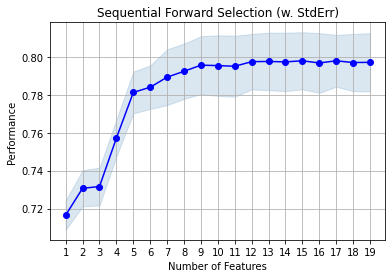

In [93]:
fig = plot_sfs(sfs1.get_metric_dict(), kind='std_err')

plt.title('Sequential Forward Selection (w. StdErr)')
plt.grid()
plt.show()

In [94]:
print(f'{len(sfs1.k_feature_names_)} Features and Accuracy Score: {sfs1.k_score_}')

19 Features and Accuracy Score: 0.7970798793694409


In [95]:
predictors=list(sfs1.k_feature_names_)
predictors

['CryoSleep',
 'VRDeck',
 'Destination_Target',
 'Cabin_Side_P',
 'cabin_deck_target',
 'ShoppingMall_log',
 'Spa_log',
 'VRDeck_log',
 'RoomService_Spa_Spend',
 'FoodCourt_Spa_Spend',
 'ShoppingMall_Spa_Spend',
 'Age_Infant',
 'Age_Teen',
 'Cabin_Deck_CryoSleep_B',
 'Cabin_Deck_CryoSleep_A',
 'Cabin_Deck_CryoSleep_D',
 'Cabin_Deck_CryoSleep_C',
 'Destination_CryoSleep_TRAPPIST-1e',
 'Destination_CryoSleep_55 Cancri e']

## 4. Preperation for Modelling

**Preparing for submission**

In [96]:
submissiontest=data[data['Transported'].notnull()==False]

In [97]:
X=labelled[predictors]
y=labelled['Transported'].astype(int) 

**Normalizing/Scaling the Data**

In [98]:
scaler = StandardScaler()
scaler.fit(X)
X=pd.DataFrame(scaler.transform(X),index=X.index, columns=X.columns)

## 5. Modelling

**Logistic Regression**

**Non-Linear Models**

In [99]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

In [100]:
classifiers = [
    LogisticRegression(),
    BaggingClassifier(),
    RandomForestClassifier(),
    GradientBoostingClassifier()]

for classifier in classifiers:
    classifier.fit(X_train, y_train) 
    y_pred=classifier.predict(X_test)
    print(classifier)
    print("model score: %.3f" % classifier.score(X_test, y_test))
    print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
    print("Precision:",metrics.precision_score(y_test, y_pred)) 
    print("Recall:",metrics.recall_score(y_test, y_pred))
    print("\n")

    

LogisticRegression()
model score: 0.782
Accuracy: 0.7824287028518859
Precision: 0.7551194539249146
Recall: 0.8263305322128851


BaggingClassifier()
model score: 0.777
Accuracy: 0.7773689052437902
Precision: 0.7595048629531388
Recall: 0.8020541549953315


RandomForestClassifier()
model score: 0.782
Accuracy: 0.7824287028518859
Precision: 0.7573149741824441
Recall: 0.8216619981325863


GradientBoostingClassifier()
model score: 0.783
Accuracy: 0.7833486660533578
Precision: 0.7479338842975206
Recall: 0.8450046685340803




**Model Tuning**

Logistic Regression

In [101]:
param_grid = {
    'penalty':['l1', 'l2', 'elasticnet'],
    'solver':['bfgs', 'liblinear','sag','saga'],
    'max_iter':[50,100,200],
    'tol':[0.01,0.001,0.0001]
}


lr = LogisticRegression()

lrrid_search = GridSearchCV(estimator = lr, param_grid = param_grid, 
                          cv = 2, n_jobs = -1, verbose = 2)

In [102]:
lrrid_search.fit(X, y)
lrrid_search.best_params_

Fitting 2 folds for each of 108 candidates, totalling 216 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 216 out of 216 | elapsed:    5.8s finished


{'max_iter': 50, 'penalty': 'l1', 'solver': 'liblinear', 'tol': 0.01}

In [103]:
lrrid_search.best_score_

0.7940887024402101

In [104]:
lr.set_params(**lrrid_search.best_params_)

LogisticRegression(max_iter=50, penalty='l1', solver='liblinear', tol=0.01)

**Bagging Classifier**

In [105]:
param_grid = {
    'base_estimator': [DecisionTreeClassifier(),LogisticRegression()],
    'n_estimators': [5, 10, 15,20],
    'max_samples': [1, 2, 4,6],
    'max_features':[1,2,3]
}


b = BaggingClassifier()

bgrid_search = GridSearchCV(estimator = b, param_grid = param_grid, 
                          cv = 2, n_jobs = -1, verbose = 2)

In [106]:
bgrid_search.fit(X, y)
bgrid_search.best_params_

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 2 folds for each of 96 candidates, totalling 192 fits


[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 192 out of 192 | elapsed:    9.8s finished


{'base_estimator': DecisionTreeClassifier(),
 'max_features': 3,
 'max_samples': 2,
 'n_estimators': 15}

In [107]:
bgrid_search.best_score_

0.7175894563547378

In [108]:
b.set_params(**bgrid_search.best_params_)

BaggingClassifier(base_estimator=DecisionTreeClassifier(), max_features=3,
                  max_samples=2, n_estimators=15)

**Random Forest**

In [109]:
param_grid = {
    'n_estimators': [50, 100, 200,400],
    'min_samples_split': [1, 2, 4,],
    'min_samples_leaf':[1,2,3],
    'max_features':['auto', 'sqrt', 'log2']
}


rf = RandomForestClassifier()

rfgrid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 2, n_jobs = -1, verbose = 2)

In [110]:
rfgrid_search.fit(X, y)
rfgrid_search.best_params_

Fitting 2 folds for each of 108 candidates, totalling 216 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   15.1s
[Parallel(n_jobs=-1)]: Done 166 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 216 out of 216 | elapsed:  1.3min finished


{'max_features': 'auto',
 'min_samples_leaf': 3,
 'min_samples_split': 4,
 'n_estimators': 100}

In [111]:
rfgrid_search.best_score_

0.7977696929006479

In [112]:
rf.set_params(**rfgrid_search.best_params_)

RandomForestClassifier(min_samples_leaf=3, min_samples_split=4)

**Gradient Boosting**

In [113]:
param_grid = {
    'n_estimators': [50,100, 200, 400],
    'min_samples_split': [2, 3],
    'max_depth': [2,3,5],
    'learning_rate':[0.01,0.1,0.5]
}

gb = GradientBoostingClassifier()

gbgrid_search = GridSearchCV(estimator = gb, param_grid = param_grid, cv = 2, n_jobs = -1, verbose = 2)

In [114]:
gbgrid_search.fit(X, y)

Fitting 2 folds for each of 72 candidates, totalling 144 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   13.9s
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed:  1.4min finished


GridSearchCV(cv=2, estimator=GradientBoostingClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.5],
                         'max_depth': [2, 3, 5], 'min_samples_split': [2, 3],
                         'n_estimators': [50, 100, 200, 400]},
             verbose=2)

In [115]:
gbgrid_search.best_params_

{'learning_rate': 0.1,
 'max_depth': 2,
 'min_samples_split': 2,
 'n_estimators': 400}

In [116]:
gb.set_params(**gbgrid_search.best_params_)

GradientBoostingClassifier(max_depth=2, n_estimators=400)

**Hyper-Tuned Models**

In [117]:
classifiers = [lr,b,rf,gb]

for classifier in classifiers:
    classifier.fit(X_train, y_train) 
    y_pred=classifier.predict(X_test)
    print(classifier)
    print("model score: %.3f" % classifier.score(X_test, y_test))
    print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
    print("Precision:",metrics.precision_score(y_test, y_pred)) 
    print("Recall:",metrics.recall_score(y_test, y_pred))
    print("\n")

    

LogisticRegression(max_iter=50, penalty='l1', solver='liblinear', tol=0.01)
model score: 0.782
Accuracy: 0.7819687212511499
Precision: 0.7553464499572284
Recall: 0.8244631185807656


BaggingClassifier(base_estimator=DecisionTreeClassifier(), max_features=3,
                  max_samples=2, n_estimators=15)
model score: 0.493
Accuracy: 0.4926402943882245
Precision: 0.4926402943882245
Recall: 1.0


RandomForestClassifier(min_samples_leaf=3, min_samples_split=4)
model score: 0.791
Accuracy: 0.7907083716651334
Precision: 0.7614601018675722
Recall: 0.8375350140056023


GradientBoostingClassifier(max_depth=2, n_estimators=400)
model score: 0.788
Accuracy: 0.7879484820607175
Precision: 0.7545909849749582
Recall: 0.8440709617180205




**Stacking**

In [118]:
models = [('lr_1', lr),
          ('rf_2', rf),
          ('gb_3',gb),
          ('b_4',b)]

clf = StackingClassifier(estimators=models, final_estimator=LogisticRegression())

clf.fit(X_train, y_train).score(X_test, y_test)

print("model score: %.3f" % clf.score(X_test, y_test))
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred)) 
print("Recall:",metrics.recall_score(y_test, y_pred))

model score: 0.790
Accuracy: 0.7879484820607175
Precision: 0.7545909849749582
Recall: 0.8440709617180205


**Voting**

In [119]:
models = [('lr_1', lr),
          ('rf_2', rf),
          ('gb_3',gb),
          ('b_4',b)]

clf = VotingClassifier(estimators=models)

clf.fit(X_train, y_train).score(X_test, y_test)

print("model score: %.3f" % clf.score(X_test, y_test))
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred)) 
print("Recall:",metrics.recall_score(y_test, y_pred))

model score: 0.792
Accuracy: 0.7879484820607175
Precision: 0.7545909849749582
Recall: 0.8440709617180205


**Final Submission**

In [120]:
X_train=X
y_train=y
X_test=submissiontest[predictors]

In [121]:
scaler = StandardScaler()
scaler.fit(X_test)
X_test=pd.DataFrame(scaler.transform(X_test),index=X_test.index, columns=X_test.columns)

In [122]:
lr.fit(X_train, y_train)
y_pred=lr.predict(X_test)

In [123]:
submission=pd.DataFrame(y_pred.astype(bool),index=X_test.index).rename(columns={0: "Transported"})

In [124]:
submission.to_csv('Submission.csv')